In [2]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

In [3]:
# Load data files
modi_path = r'D:\project\election prediction\ModiRelatedTweetsWithSentiment.csv'
rahul_path = r'D:\project\election prediction\RahulRelatedTweetsWithSentiment.csv'  # Placeholder for Rahul's CSV file

In [4]:
# Load Modi data
data_modi = pd.read_csv(modi_path)
data_rahul = pd.read_csv(rahul_path) if os.path.exists(rahul_path) else pd.DataFrame()

In [5]:
# Drop missing or irrelevant columns
data_modi = data_modi.dropna(subset=['Tweet', 'Emotion'])
data_rahul = data_rahul.dropna(subset=['Tweet', 'Emotion'])


In [6]:
# Add candidate labels
data_modi['candidate'] = 'Modi'
data_rahul['candidate'] = 'Rahul'

# Combine datasets
data = pd.concat([data_modi[['Tweet', 'Emotion', 'candidate']], 
                  data_rahul[['Tweet', 'Emotion', 'candidate']]], ignore_index=True)

In [7]:
# Text preprocessing
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text
data['cleaned_tweet'] = data['Tweet'].apply(preprocess_text)

In [8]:
# Encode sentiments as 1 (positive) and 0 (negative)
data['sentiment'] = data['Emotion'].apply(lambda x: 1 if x == 'pos' else 0)

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_tweet'], data['sentiment'], test_size=0.2, random_state=42)


In [10]:
# Create a simple vocabulary from training data
def build_vocabulary(corpus):
    vocab = Counter()
    for text in corpus:
        vocab.update(text.split())
    return {word: idx for idx, word in enumerate(vocab.keys())}

def text_to_vector(text, vocab):
    vector = [0] * len(vocab)
    for word in text.split():
        if word in vocab:
            vector[vocab[word]] += 1
    return vector

vocab = build_vocabulary(X_train)
X_train_vectors = [text_to_vector(text, vocab) for text in X_train]
X_test_vectors = [text_to_vector(text, vocab) for text in X_test]


In [11]:
# Train a simple classifier
def train_naive_bayes(X, y):
    pos_counts = Counter()
    neg_counts = Counter()
    pos_total = neg_total = 0

    for vector, label in zip(X, y):
        for idx, count in enumerate(vector):
            if label == 1:
                pos_counts[idx] += count
                pos_total += count
            else:
                neg_counts[idx] += count
                neg_total += count

    pos_probs = {idx: (pos_counts[idx] + 1) / (pos_total + len(X[0])) for idx in range(len(X[0]))}
    neg_probs = {idx: (neg_counts[idx] + 1) / (neg_total + len(X[0])) for idx in range(len(X[0]))}

    return pos_probs, neg_probs, pos_total / (pos_total + neg_total), neg_total / (pos_total + neg_total)

def predict_naive_bayes(X, pos_probs, neg_probs, pos_prior, neg_prior):
    predictions = []
    for vector in X:
        pos_score = pos_prior
        neg_score = neg_prior

        for idx, count in enumerate(vector):
            if count > 0:
                pos_score *= pos_probs.get(idx, 1 / (sum(pos_probs.values()))) ** count
                neg_score *= neg_probs.get(idx, 1 / (sum(neg_probs.values()))) ** count

        predictions.append(1 if pos_score > neg_score else 0)
    return predictions


In [12]:
# Train the model
pos_probs, neg_probs, pos_prior, neg_prior = train_naive_bayes(X_train_vectors, y_train)


In [13]:
# Evaluate the model
y_pred = predict_naive_bayes(X_test_vectors, pos_probs, neg_probs, pos_prior, neg_prior)
print("Model Accuracy:", accuracy_score(y_test, y_pred))


Model Accuracy: 0.7602954061835023


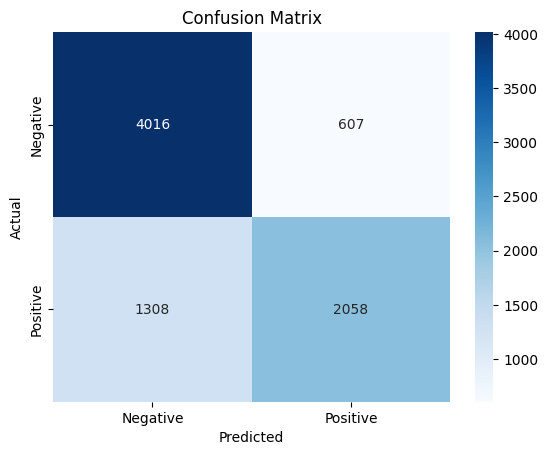

In [14]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Predict winner
data['prediction'] = predict_naive_bayes(
    [text_to_vector(text, vocab) for text in data['cleaned_tweet']],
    pos_probs, neg_probs, pos_prior, neg_prior
)

modi_positive = data[(data['candidate'] == 'Modi') & (data['prediction'] == 1)].shape[0]
rahul_positive = data[(data['candidate'] == 'Rahul') & (data['prediction'] == 1)].shape[0]

if modi_positive > rahul_positive:
    print(f"Prediction: Modi is likely to win based on sentiment analysis. (Positive Tweets: {modi_positive})")
else:
    print(f"Prediction: Rahul is likely to win based on sentiment analysis. (Positive Tweets: {rahul_positive})")
